In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sentence_transformers import SentenceTransformer   # if you use SciBERT
import pandas as pd
from tqdm import tqdm
import numpy as np
from collections import Counter


import ast
import json
import os
import pickle
import re
from math import ceil

import joblib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t
from sklearn.preprocessing import FunctionTransformer


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from lightgbm import LGBMClassifier

from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    hamming_loss,
    make_scorer,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    ParameterGrid,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# The data

In [76]:
# the data

df = pd.read_csv(r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\coding_trial\testData13052025.csv")
df = df.drop(columns = 'Unnamed: 0')


# add a column for which data was really randomly sampled
# this avoid testing on oversampled sparse classes

df['is_random'] = np.where(df.batch.isin(['batch1', 'batch2_m', 'batch2_s', 'batch2_l', 'batch2_j',
       'batch3_l']),1,0)
df['paper_id'] = [i.split(".json")[0] for i in df.id.values]
df.head(2)

,phenotype,phen_data,morph,quant_morph,qual_morph,color_pattern,shape,texture,ultrastruct,interbr_morph,...,nomenclat_history,biogeo,id,displayed_text,checked,sequencing,batch,not important,is_random,paper_id
0,1,1,1,1,0,0,0,0,0,0,...,0,0,./Corpus/EJT/10_5852_ejt_2021_735_1243.json_0,The material examined was collected in fragmen...,0,0,batch1,NaN,1,./Corpus/EJT/10_5852_ejt_2021_735_1243
1,1,0,0,0,0,0,0,0,0,0,...,0,0,./Corpus/Zootaxa/1/zootaxa_1920_1_5.json_0,Invertebrate samples\nwere collected using a h...,0,0,batch1,NaN,1,./Corpus/Zootaxa/1/zootaxa_1920_1_5


In [13]:
# load list with categories of interest
filename = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\categories_of_interest.txt"
with open(filename, 'r') as file:
    cats = json.load(file)

# load the dictionary to map category column names to gpt names
filename = r'C:\\Users\\conix\\Dropbox\\FNRS project taxonomy\\methods in taxonomy\\data\\category_names_dict.txt'
with open(filename, 'r') as file:
    category_names = json.load(file)

# descriptions of the various categories, used in the first try with gpt4omini
filename = r'C:\\Users\\conix\\Dropbox\\FNRS project taxonomy\\methods in taxonomy\\data\\methods_description_gpt4omini_first_try.txt'
with open(filename, 'r') as file:
    methods_old = json.load(file)

# descriptions of the various categories, used in the second try with gpt4omini
filename = r'C:\\Users\\conix\\Dropbox\\FNRS project taxonomy\\methods in taxonomy\\data\\methods_description_gpt4omini_second_try.txt'
with open(filename, 'r') as file:
    methods = json.load(file)

# hierarchical classification of the categories
filename = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\classification_categories.txt"
with open(filename, "r") as file:
    classif = json.load(file)

In [21]:
rand_df   = df[df['is_random'] == 1]      # unbiased rows
biased_df = df[df['is_random'] == 0]      # rows from biased sampling (to increase sparse categories)

X_rand, y_rand = rand_df['displayed_text'], rand_df[cats]
X_bias, y_bias = biased_df['displayed_text'], biased_df[cats]

# take 80/20 split from the unbiased part
# use this for training, not for validation or testing
# the biased samples are only used for training, i.e. appended to the training data within each fold's training set
# at the final retraining, the biased samples are also used for training
msss = MultilabelStratifiedShuffleSplit(test_size=0.20, random_state=42)
train_idx, test_idx = next(msss.split(X_rand, y_rand))

X_train_raw, y_train_raw = X_rand.iloc[train_idx], y_rand.iloc[train_idx]
X_test,      y_test      = X_rand.iloc[test_idx],  y_rand.iloc[test_idx]

class_frequencies = y_train_raw.sum(axis=0).values


# features & pipeline skeleton—unchanged
tfidf  = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95,
                         sublinear_tf=True, norm='l2', dtype=np.float32,
                         lowercase=True, strip_accents='unicode')

# for estimators that don't accept sparse matrices (rf, knn, gb)
densify = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

# we choose macro_F1 as our classes are very imbalanced, and many are very sparse
score   = make_scorer(f1_score, average='macro')

# use multilabelstratifiedkfold to keep the label proportions roughly equal
# 5 folds in the outer loop (for model evaluation)
outer = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 5 folds in the inner loop (for hyperparameter tuning)
inner = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [22]:
# save the data for upload

upload_data_lr = {'training data':{'X_train_combined': pd.concat([X_train_raw, X_bias]), 'y_train_combined':pd.concat([y_train_raw, y_bias]), 'X_train_raw':X_train_raw, 'X_bias':X_bias, 'y_train_raw':y_train_raw, 'y_bias':y_bias, 'train_idx':train_idx},
              'test data':{'X_test':X_test, 'y_test':y_test, 'test_idx':test_idx}, 
              'og_data': df,
              'class_frequencies':class_frequencies,
               'labels':cats
              }

with open("methods_paper_files/upload_data_lr.pkl", "wb") as f:
    pickle.dump(upload_data_lr, f)

To make it computationally feasible, but also tune all hyperparameters, we'll go in different steps:
1) choose a feature family, using standard LR hyperparameters.
2) tune the chosen feature family, using standard LR hyperparameters.
3) tune LR, using the chosen feature family.

We also tune thresholds, but that's part of the nested CV. This is done by storing the probabilities, and using the held out validation set to tune thresholds. This way, there is no real leakage.

# STEP 1: Select a feature family

In the CompareCLassifiers notebook, we chose between various classic ML models and chose LR. For that, we used a standard feature configuration. Now that we've chosen LR, we'll do CV to find the best feature family for our job.

## helper functions for nested cv

Instead of using a validation set, we do nested cross validation. We start by writing helper functions for running it, as we'll need it in all three steps of our approach.

In [31]:
# calculate metrics for reporting and validation
def fold_metrics(y_true, y_pred):
    """Return overall + per-label metrics in a flat dict."""
    out = {
        'macro_f1'  : f1_score(y_true, y_pred, average='macro'),
        'micro_f1'  : f1_score(y_true, y_pred, average='micro'),
        'macro_prec': precision_score(y_true, y_pred, average='macro'),
        'micro_prec': precision_score(y_true, y_pred, average='micro'),
        'macro_rec' : recall_score(y_true, y_pred, average='macro'),
        'micro_rec' : recall_score(y_true, y_pred, average='micro'),
        'hamming'   : hamming_loss(y_true, y_pred),
        'subset_acc': accuracy_score(y_true, y_pred),
    }
    p, r, f, s = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    for i, lab in enumerate(y_true.columns):
        out[f'{lab}_prec'] = p[i]
        out[f'{lab}_rec']  = r[i]
        out[f'{lab}_f1']   = f[i]
        out[f'{lab}_sup']  = s[i]
    return out

# function to run nested cross validation
# we'll need this function in various steps

def cv_with_stats(pipe, grid, thresh_grid=np.arange(0.20, 0.81, 0.0125)):
    outer_oof   = np.zeros((len(X_train_raw), len(cats)), dtype=np.float32)
    outer_truth = y_train_raw.values.copy()
    scores, best_params = [], []

    # wrap the generator in tqdm → one tick per fold
    for fold, (train_idx, val_idx) in enumerate(
            tqdm(outer.split(X_train_raw, y_train_raw),
                 total=outer.get_n_splits(), desc="Outer CV"), 1):

        X_tr = pd.concat([X_train_raw.iloc[train_idx], X_bias])
        y_tr = pd.concat([y_train_raw.iloc[train_idx], y_bias])
        X_val, y_val = X_train_raw.iloc[val_idx], y_train_raw.iloc[val_idx]

        tuner = GridSearchCV(pipe, grid, scoring=score, cv=inner,
                             n_jobs=-1, verbose=0)
        tuner.fit(X_tr, y_tr)
        best_params.append(tuner.best_params_)

        outer_oof[val_idx, :] = tuner.predict_proba(X_val)

        fold_pred = (outer_oof[val_idx] >= 0.5).astype(int)
        scores.append(fold_metrics(y_val, fold_pred))

    # pooled threshold search (unchanged) …
    thresholds = []
    for j in range(outer_oof.shape[1]):
        best_f1, best_thr = -1.0, 0.5
        y_true = outer_truth[:, j]
        for thr in thresh_grid:
            y_bin = (outer_oof[:, j] >= thr)
            f1    = f1_score(y_true, y_bin, zero_division=0)
            if f1 > best_f1:
                best_f1, best_thr = f1, thr
        thresholds.append(best_thr)

    df_scores = pd.DataFrame(scores)
    return {
        "mean"      : df_scores.mean(),
        "std"       : df_scores.std(ddof=1),
        "ci_95"     : df_scores.quantile([0.025, 0.975]),
        "fold_df"   : df_scores,
        "best_params": best_params,
        "thresholds": thresholds,
    }


## Feature families

We'll try scibert, plain tf-idf, character and word tf-idf, and tf-idf combined with dimensionality reduction via truncated SVD.

In [17]:
# precompute the scibert embeddings

sbert = SentenceTransformer(
    'jordyvl/scibert_scivocab_uncased_sentence_transformer'
)

# encode all texts in one go
texts = df['displayed_text'].tolist()
all_embs = sbert.encode(
    texts,
    batch_size=32,
    show_progress_bar=True
)

np.save('methods_paper_files/sciBERT_embs.npy', all_embs)

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

In [18]:
# load the embeddings and define a function to use them

all_embs = np.load('methods_paper_files/sciBERT_embs.npy')

# a lookup transformer that pulls rows by index
def emb_lookup(X):
    return all_embs[X]

sbert_lookup = FunctionTransformer(func=lambda inds: emb_lookup(inds), validate=False)


In [20]:
# define feature and minimal lr grid

feature_grid = {
    'sciBERT': Pipeline([
    # 1-D array of indices, not a 2-D column
    ('idx', FunctionTransformer(lambda X: X.index.values, validate=False)),
    ('emb', sbert_lookup)
]),
    'plain_12': TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95,
                                sublinear_tf=True, norm='l2'),
    'char_union': FeatureUnion([
        ('word', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ('char', TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2))
    ]),
    'lsa_300': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ('svd', TruncatedSVD(300, random_state=42))
    ])
    
}

# we will tune these parameters later.
# just a minimal grid now to make sure we give all feature families a fair chance

param_grid = {
    'clf__estimator__C':            [0.01, 0.1, 1, 10],
    'clf__estimator__class_weight': [None, 'balanced']
}

## Compare feature families using gridsearch

In [28]:
feature_results = {}   # mean metrics per family
feature_folds   = {}   # n_folds×metrics DataFrame per family
feature_best_params = {}

for name, vect in tqdm(feature_grid.items(), desc="Feature sets"):
    pipe = Pipeline([
        ('vect', vect),
        ('clf',  OneVsRestClassifier(
                    LogisticRegression(max_iter=2000, solver='lbfgs')
                ))
    ])
    # now pass the grid so LR is tuned for *this* representation
    res = cv_with_stats(pipe, param_grid)
    
    feature_folds[name]   = res['fold_df']   # 5 outer-fold rows
    feature_results[name] = res['mean']      # mean across folds
    feature_best_params[name] = res['best_params']


feat_df = (
    pd.DataFrame(feature_results)
      .T.sort_values('macro_f1', ascending=False)
      [['macro_f1', 'micro_f1']]
)
print("\nFeature-set comparison (tuned LR on each family):\n", feat_df)

best_feat_name = feat_df.index[0]
BEST_FEATURE_PIPE = feature_grid[best_feat_name]
print(f"\nBest feature configuration: {best_feat_name}")

Feature sets: 100%|███████████████████████████████████████████████████████████████████| 4/4 [1:06:07<00:00, 991.85s/it]


Feature-set comparison (tuned LR on each family):
             macro_f1  micro_f1
plain_12    0.718778  0.817916
char_union  0.711081  0.814621
lsa_300     0.705863  0.801031
sciBERT     0.664533  0.771111

Best feature configuration: plain_12


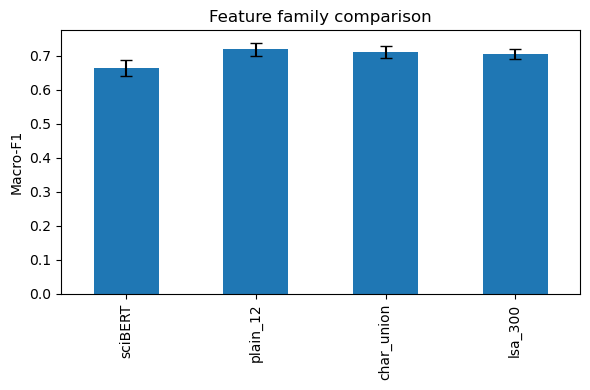


Paired bootstrap tests vs plain_12 :
         vs  Δ mean(F1)  CI_low  CI_high  p_two-sided
   sciBERT       0.054   0.048    0.059        0.000
char_union       0.008   0.003    0.016        0.000
   lsa_300       0.013  -0.003    0.027        0.122


In [29]:
# build a 5×4 table of macro-F1
macro_scores = pd.DataFrame({
    name: df['macro_f1'].values
    for name, df in feature_folds.items()
})

# plot means ±95% CI
n = len(macro_scores)
means = macro_scores.mean()
ses   = macro_scores.std(ddof=1) / np.sqrt(n)
cis   = ses * t.ppf(0.975, df=n-1)

ax = means.plot(kind='bar', yerr=cis, capsize=4, figsize=(6,4))
ax.set_ylabel("Macro-F1"); ax.set_title("Feature family comparison")
plt.tight_layout()
plt.show()

# paired bootstrap vs best
best = means.idxmax()
comparisons = []
B = 5000
for fam in macro_scores.columns:
    if fam == best: continue
    diff = macro_scores[best] - macro_scores[fam]
    boots = np.random.choice(diff, (B, len(diff)), replace=True).mean(axis=1)
    lo, hi = np.percentile(boots, [2.5, 97.5])
    p = (np.mean(boots < 0) if diff.mean()>0 else np.mean(boots>0))*2
    comparisons.append({
        'vs': fam,
        'Δ mean(F1)': diff.mean(),
        'CI_low': lo, 'CI_high': hi,
        'p_two-sided': p
    })
comp_df = pd.DataFrame(comparisons).round(3)
print("\nPaired bootstrap tests vs", best, ":\n", comp_df.to_string(index=False))

# Step 2: Tune TF-IDF

Now that we know TF-IDF is best, we further tune it by exploring more possible values.

In [35]:
# Plain TF‑IDF vectoriser
plain_tfidf = TfidfVectorizer(
    analyzer='word',          
    norm='l2',
    sublinear_tf=True         
)

# Pipeline
pipe = Pipeline([
    ('vect', plain_tfidf),
    ('clf', OneVsRestClassifier(
        LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1)
    ))
], memory=joblib.Memory(location="~/tmp/pipeline_cache"))

# Hyper‑parameter grid – “extensive but sane”
param_grid = {
    # TF‑IDF
    'vect__ngram_range' : [(1,1), (1,2), (1,3), (2,2)],
    'vect__min_df'      : [1, 2, 5, 10],
    'vect__max_df'      : [0.8, 0.9, 0.95],
    'vect__stop_words'  : [None, 'english'],

    # Logistic‑regression
    'clf__estimator__C'           : [0.1, 1, 10],
    'clf__estimator__class_weight': ['balanced'],
}

# Nested CV
tfidf_stats = cv_with_stats(pipe, param_grid)

Outer CV:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.8, min_df=10, stop_words='english', sublinear_tf=True), 2       The nymphs were collected in the stream by han...
3       We verified both the endemic status and the di...
4       During each cruise, specimens were sorted onbo...
5       DNA from frozen or alcohol preserved liver or ...
6       Specimens were collected in the Northeast of C...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1303, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imag

Outer CV:  20%|██████████████                                                        | 1/5 [30:50<2:03:20, 1850.24s/it]

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.8, min_df=5, sublinear_tf=True), 1       Invertebrate samples\nwere collected using a h...
2       The nymphs were collected in the stream by han...
4       During each cruise, specimens were sorted onbo...
5       DNA from frozen or alcohol preserved liver or ...
6       Specimens were collected in the Northeast of C...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1302, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imaging  \
1             1 

Outer CV:  40%|███████████████████████████▏                                        | 2/5 [1:00:10<1:29:51, 1797.07s/it]

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.95, min_df=10, sublinear_tf=True), 1       Invertebrate samples\nwere collected using a h...
3       We verified both the endemic status and the di...
4       During each cruise, specimens were sorted onbo...
8       The species redescription and the illustration...
9       Bootstrap support was calculated with 1000 rep...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1303, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imaging  \
1             

Outer CV:  60%|██████████████████████████████████████████                            | 3/5 [1:30:08<59:55, 1797.68s/it]

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.95, min_df=10, sublinear_tf=True), 1       Invertebrate samples\nwere collected using a h...
2       The nymphs were collected in the stream by han...
3       We verified both the endemic status and the di...
4       During each cruise, specimens were sorted onbo...
5       DNA from frozen or alcohol preserved liver or ...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1302, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imaging  \
1             

Outer CV:  80%|████████████████████████████████████████████████████████              | 4/5 [1:59:54<29:52, 1792.96s/it]

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.95, min_df=5, sublinear_tf=True), 1       Invertebrate samples\nwere collected using a h...
2       The nymphs were collected in the stream by han...
3       We verified both the endemic status and the di...
5       DNA from frozen or alcohol preserved liver or ...
6       Specimens were collected in the Northeast of C...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1302, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imaging  \
1             1

Outer CV: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [2:29:46<00:00, 1797.33s/it]


In [38]:
# save results
with open("methods_paper_files/tfidf_stats.pkl", "wb") as f:
    pickle.dump(tfidf_stats, f)


In [39]:
# get best params

params_per_fold = tfidf_stats['best_params']     
scores_per_fold = tfidf_stats['fold_df']['macro_f1']


df = pd.DataFrame({
    "params": params_per_fold,
    "fold_score": scores_per_fold
})

# Convert the param dictionaries to strings so we can group them
df["param_key"] = df["params"].apply(lambda d: str(sorted(d.items())))

mean_scores = (df
               .groupby("param_key")["fold_score"]
               .mean()
               .sort_values(ascending=False))

best_key = mean_scores.index[0]
best_params = eval(best_key)        # back to a dict
print("Chosen params:", best_params)

Chosen params: [('clf__estimator__C', 10), ('clf__estimator__class_weight', 'balanced'), ('vect__max_df', 0.95), ('vect__min_df', 5), ('vect__ngram_range', (1, 1)), ('vect__stop_words', None)]


# Step 3: Tune LR using the chosen tf idf configuration

Now that we know which parameters are best for tf-idf, we can tune the parameters of LR.

In [49]:
# best params for these
plain_tfidf = TfidfVectorizer(
    analyzer='word',
    norm='l2',
    sublinear_tf=True,
    max_df=0.95,          
    min_df=5,             
    ngram_range=(1, 1),   
    stop_words=None       
)

lr_pipe = Pipeline([
    ('vect', plain_tfidf),
    ('clf', OneVsRestClassifier(
        LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1)
    ))
], memory=joblib.Memory(location="~/tmp/pipeline_cache"))


# try two solvers
SOLVER_SPARSE = 'saga'   
SOLVER_DENSE  = 'lbfgs'  

param_grid = [
    # —— saga, L2 ———————————————————————————
    {
        'clf__estimator__solver':  [SOLVER_SPARSE],
        'clf__estimator__penalty': ['l2'],
        'clf__estimator__C':       [1e-3, 1e-2, 1e-1, 1, 10, 100],
        'clf__estimator__class_weight': ['balanced'],
    },
    # —— saga, L1 ———————————————————————————
    {
        'clf__estimator__solver':  [SOLVER_SPARSE],
        'clf__estimator__penalty': ['l1'],
        'clf__estimator__C':       [1e-3, 1e-2, 1e-1, 1, 10, 100],
        'clf__estimator__class_weight': ['balanced'],
    },
    # —— saga, elastic‑net ——————————————
    {
        'clf__estimator__solver':  [SOLVER_SPARSE],
        'clf__estimator__penalty': ['elasticnet'],
        'clf__estimator__l1_ratio': [0.1, 0.5, 0.9],
        'clf__estimator__C':       [1e-3, 1e-2, 1e-1, 1, 10, 100],
        'clf__estimator__class_weight': ['balanced'],
    },
    # —— lbfgs, L2 ——————————————————————————
    {
        'clf__estimator__solver':  [SOLVER_DENSE],
        'clf__estimator__penalty': ['l2'],
        'clf__estimator__C':       [1e-3, 1e-2, 1e-1, 1, 10, 100],
        'clf__estimator__class_weight': ['balanced'],
    },
    # —— lbfgs, no regularisation ——————————
    {
        'clf__estimator__solver':  [SOLVER_DENSE],
        'clf__estimator__penalty': ['None'],
        'clf__estimator__class_weight': ['balanced'],
    },
]

# run nested cv
best_lr_stats = cv_with_stats(lr_pipe, param_grid)

Outer CV:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 185.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conix\.

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.95, min_df=5, sublinear_tf=True), 1       Invertebrate samples\nwere collected using a h...
2       The nymphs were collected in the stream by han...
4       During each cruise, specimens were sorted onbo...
5       DNA from frozen or alcohol preserved liver or ...
6       Specimens were collected in the Northeast of C...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1302, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imaging  \
1             1

Outer CV:  40%|███████████████████████████▏                                        | 2/5 [1:11:21<1:46:48, 2136.15s/it]C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 185.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conix\.

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.95, min_df=5, sublinear_tf=True), 1       Invertebrate samples\nwere collected using a h...
3       We verified both the endemic status and the di...
4       During each cruise, specimens were sorted onbo...
8       The species redescription and the illustration...
9       Bootstrap support was calculated with 1000 rep...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1303, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imaging  \
1             1

Outer CV:  60%|████████████████████████████████████████▊                           | 3/5 [1:46:31<1:10:48, 2124.43s/it]C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 185.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conix\.

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfVectorizer(max_df=0.95, min_df=5, sublinear_tf=True), 1       Invertebrate samples\nwere collected using a h...
2       The nymphs were collected in the stream by han...
3       We verified both the endemic status and the di...
4       During each cruise, specimens were sorted onbo...
5       DNA from frozen or alcohol preserved liver or ...
                              ...                        
1840    5.6.21 software (Xia 2013). For COI, saturatio...
1841    Collecting and culture of tardigrades\nSamples...
1842    (air temperature 13.2°C, and the weather condi...
1843    These were assigned to H.tenuis, H.convexinota...
1844    The description of each stage and period was b...
Name: displayed_text, Length: 1302, dtype: object, 
      phenotype  phen_data  morph  biogeo  color_pattern  phen_proc  imaging  \
1             1

Outer CV:  80%|████████████████████████████████████████████████████████              | 4/5 [2:25:43<36:54, 2214.19s/it]C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 185.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\conix\.conda\envs\TM_env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\conix\.

In [88]:
# save results
with open("methods_paper_files/best_lr_stats.pkl", "wb") as f:
    pickle.dump(best_lr_stats, f)

In [60]:
print("\nNested-CV macro/micro-F1 (plain tf-idf + LR grid):")
print(best_lr_stats['mean'][['macro_f1', 'micro_f1']])

best_params = best_lr_stats['best_params']

agg_params = {}
for param in best_params[0].keys():
    # count how many times each value was chosen
    cnt = Counter(d[param] for d in best_params)
    # pick the most common
    agg_params[param] = cnt.most_common(1)[0][0]

print("Aggregated best params:", agg_params)

best_global_thresh = np.array(best_lr_stats["thresholds"])
print("Best thresholds:", best_global_thresh)


Nested-CV macro/micro-F1 (plain tf-idf + LR grid):
macro_f1    0.755700
micro_f1    0.821548
dtype: float64
Aggregated best params: {'clf__estimator__C': 10, 'clf__estimator__class_weight': 'balanced', 'clf__estimator__l1_ratio': 0.9, 'clf__estimator__penalty': 'elasticnet', 'clf__estimator__solver': 'saga'}
Best thresholds: [0.225  0.3125 0.3125 0.3125 0.475  0.325  0.375  0.525  0.475  0.5
 0.3375 0.5875 0.3    0.4875 0.5125 0.6125 0.25   0.2375 0.4125 0.55
 0.4875 0.2625 0.6875 0.375  0.55   0.3875 0.625  0.5625 0.6875 0.3625
 0.3125 0.525  0.7    0.4375 0.6375 0.5375 0.375  0.4375]


In [67]:
# IF COMING FROM TUNING:

best_params = best_lr_stats['best_params']
agg_params  = {}
for k in best_params[0]:
    vals = [d[k] for d in best_params]
    try:
        agg_params[k] = Counter(vals).most_common(1)[0][0]
    except TypeError:          # un‑hashable → fall back to first value
        agg_params[k] = vals[0]

# Build pipeline with exactly those params
tfidf_params = {k.split('__', 1)[1]                 : v for k, v in agg_params.items()
                if k.startswith('vect__')}
lr_params    = {k.split('__', 2)[2]                 : v for k, v in agg_params.items()
                if k.startswith('clf__estimator__')}

# make sure we have a solver 
if 'solver' not in lr_params:
    lr_params['solver'] = 'saga'        # fallback; remove if you don’t want it

# build the objects
plain_tfidf = TfidfVectorizer(**tfidf_params)

logreg = LogisticRegression(max_iter=int(2e4), **lr_params)

final_pipe = Pipeline([
    ('vect', plain_tfidf),
    ('clf',  OneVsRestClassifier(logreg))
])

# fit
final_pipe.fit(pd.concat([X_train_raw, X_bias]),
               pd.concat([y_train_raw,  y_bias]))


Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10,
                                                                  class_weight='balanced',
                                                                  l1_ratio=0.9,
                                                                  max_iter=20000,
                                                                  penalty='elasticnet',
                                                                  solver='saga')))])

In [84]:
# IF NOT COMING FROM TUNING: 

best_global_thresh =  [0.225 , 0.3125 ,0.3125 ,0.3125 ,0.475,  0.325 , 0.375 , 0.525 , 0.475 , 0.5,
 0.3375 ,0.5875, 0.3    ,0.4875 ,0.5125, 0.6125, 0.25 ,  0.2375, 0.4125, 0.55,
 0.4875, 0.2625, 0.6875, 0.375 , 0.55,   0.3875, 0.625,  0.5625, 0.6875, 0.3625,
 0.3125 ,0.525,  0.7 ,   0.4375, 0.6375, 0.5375, 0.375,  0.4375]

plain_tfidf = TfidfVectorizer(
    analyzer='word',
    norm='l2',
    sublinear_tf=True,
    max_df=0.95,          
    min_df=5,             
    ngram_range=(1, 1),   
    stop_words=None       
)



final_pipe = Pipeline([
    ('vect', plain_tfidf), 
    ('clf', OneVsRestClassifier(
        LogisticRegression(
            C=10,
            class_weight='balanced',
            max_iter=2e4,
            solver='saga',
            penalty = 'elasticnet',
            l1_ratio = 0.9
        )
    ))
])

final_pipe.fit(
    pd.concat([X_train_raw, X_bias]),
    pd.concat([y_train_raw, y_bias])
)

Pipeline(steps=[('vect',
                 FeatureUnion(transformer_list=[('word',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=5)),
                                                ('char',
                                                 TfidfVectorizer(analyzer='char_wb',
                                                                 ngram_range=(2,
                                                                              5)))],
                              transformer_weights={'char': 1.0, 'word': 1.0})),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10,
                                                                  class_weight='balanced',
                                                                  max_iter=1000)))])

In [68]:
# save
model_payload = {
    'pipeline': final_pipe,
    'thresholds': best_global_thresh,
    'label_names': y_train_raw.columns.tolist()  
}
joblib.dump(model_payload, "methods_paper_files/results/final_lr_model.pkl")
print("Model + thresholds saved to final_lr_model.pkl")


Model + thresholds saved to final_lr_model.pkl


In [69]:
# load the model
payload = joblib.load("methods_paper_files/results/final_lr_model.pkl")

# unpack
final_pipe   = payload["pipeline"]
agg_thresh   = payload["thresholds"]
label_names  = payload["label_names"]

In [ ]:
# function to propagate the hierarchy through the classifier results
# this at least partially captures label relations in this binary-relevance strategy
def propagate_hierarchy(pred_df, classif):
    """Return a copy where every parent/cross-link label is made 1
       if any of its children are 1."""
    out = pred_df.copy()

    def recurse(node):
        if isinstance(node, dict):
            for parent, children in node.items():
                recurse(children)
                child_keys = []
                for c in children:
                    if isinstance(c, str):
                        child_keys.append(c)
                    elif isinstance(c, dict):
                        child_keys.extend(c.keys())
                if child_keys:
                    out.loc[out[child_keys].eq(1).any(axis=1), parent] = 1
        elif isinstance(node, list):
            for item in node:
                recurse(item)

    recurse(classif)

    # cross-links outside the hierarchical classification
    if {'interbr_morph','gen_interbr','interbreeding'}.issubset(out):
        mask = (out.interbr_morph==1)|(out.gen_interbr==1)
        out.loc[mask, 'interbreeding'] = 1

    if {'distance_based','distance'}.issubset(out):
        out.loc[out.distance_based==1, 'distance'] = 1

    if {'phen_pylo','phylo_sd','phylo_tree','phylogenetic'}.issubset(out):
        mask = (out.phen_pylo==1)|(out.phylo_sd==1)|(out.phylo_tree==1)
        out.loc[mask, 'phylogenetic'] = 1

    return out


In [70]:
# Compute raw probabilities on X_test
proba_test = final_pipe.predict_proba(X_test) 

# Binarize using agg_thresh (one cutoff per column)
y_test_hat = (proba_test >= np.array(agg_thresh)).astype(int)

# Build DataFrame, enforce hierarchy, and align columns
test_df = pd.DataFrame(y_test_hat, columns=y_test.columns, index=X_test.index)
test_df = propagate_hierarchy(test_df, classif).fillna(0).astype(int)
test_df = test_df.reindex(columns=y_test.columns, fill_value=0)

# Compute metrics
final_metrics = fold_metrics(y_test, test_df.values)
print("Final held-out test macro-F1:", final_metrics['macro_f1'])
print("Final held-out test micro-F1:", final_metrics['micro_f1'])

Final held-out test macro-F1: 0.7640602968387167
Final held-out test micro-F1: 0.8324240062353858


In [81]:
# save the data to analyze somewhere else
test_df = test_df.reset_index(drop=True)
logit_df = pd.DataFrame(proba_test, columns = [f"{i}_logit" for i in cats])
label_df = test_df
id_df = df.iloc[test_idx][["id","paper_id","displayed_text"]].reset_index(drop=True)

lr_df = logit_df.join(label_df, how='inner')
lr_df = lr_df.join(id_df, how='inner')
df_true = df.iloc[test_idx]

with open("methods_paper_files/results/lr_results_df.pkl", "wb") as f:
    pickle.dump(lr_df, f)

with open("methods_paper_files/results/df_true.pkl", "wb") as f:
    pickle.dump(df_true, f)

print(lr_df.shape)
lr_df.head()

(304, 79)


,phenotype_logit,phen_data_logit,morph_logit,biogeo_logit,color_pattern_logit,phen_proc_logit,imaging_logit,quant_morph_logit,storage_logit,sampling_logit,...,phen_pylo,distance_based,acoustic,phylo_sd,interbreeding,specimen_storage_loc,abbrev_terms,id,paper_id,displayed_text
0,0.996033,0.984249,0.977340,0.127748,0.079911,0.989590,0.959326,0.853821,0.235568,0.938342,...,0,0,0,0,0,0,1,./Corpus/EJT/10_5852_ejt_2021_735_1243.json_0,./Corpus/EJT/10_5852_ejt_2021_735_1243,The material examined was collected in fragmen...
1,0.958663,0.847289,0.629694,0.113914,0.006551,0.919240,0.625631,0.107309,0.454085,0.304208,...,0,0,0,0,0,0,1,./Corpus/Zootaxa/4/3/zootaxa_4312_3_5.json_0,./Corpus/Zootaxa/4/3/zootaxa_4312_3_5,Redescription is based on freshly collected to...
2,0.997683,0.514083,0.329476,0.827798,0.059827,0.997679,0.279543,0.281173,0.997169,0.997751,...,0,0,0,0,0,1,0,./Corpus/Zootaxa/4/3/zootaxa_4312_3_3.json_0,./Corpus/Zootaxa/4/3/zootaxa_4312_3_3,Specimens were collected during field surveys ...
3,0.931685,0.938375,0.938753,0.344281,0.127859,0.229098,0.110262,0.147350,0.034864,0.125227,...,0,0,0,0,0,0,0,./Corpus/EJT/10_5852_ejt_2021_771_1503.json_2,./Corpus/EJT/10_5852_ejt_2021_771_1503,European Journal of Taxonomy 771: 1–79 (2021)\...
4,0.921157,0.160630,0.109707,0.017274,0.005713,0.963469,0.983961,0.022437,0.870971,0.387865,...,0,0,0,0,0,0,0,./Corpus/Zootaxa/3/7/zootaxa_3785_4_6.json_0,./Corpus/Zootaxa/3/7/zootaxa_3785_4_6,Nematodes were\nextracted using the tray metho...
